This first part is only needed as we have to mock VASP here as we cannot run it directly in a jupyter notebook:

In [1]:
from mock_vasp import TEST_DIR, mock_vasp

ref_paths = {
    "tight relax 1": "Si_gruneisen_tutorial/tight_relax_1_0",
    "tight relax 2": "Si_gruneisen_tutorial/tight_relax_2_1",
    "tight relax 1 plus": "Si_gruneisen_tutorial/tight_relax_1_plus_3",
    "tight relax 2 plus": "Si_gruneisen_tutorial/tight_relax_2_plus_5",
    "tight relax 1 minus": "Si_gruneisen_tutorial/tight_relax_1_minus_4",
    "tight relax 2 minus": "Si_gruneisen_tutorial/tight_relax_2_minus_6",
    "dft phonon static 1/1 ground": "Si_gruneisen_tutorial/dft_phonon_static_1_1_ground_24",
    "dft phonon static 1/1 plus": "Si_gruneisen_tutorial/dft_phonon_static_1_1_plus_26",
    "dft phonon static 1/1 minus": "Si_gruneisen_tutorial/dft_phonon_static_1_1_minus_28",
}

/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from atomate2.vasp.flows.core import DoubleRelaxMaker
from atomate2.vasp.jobs.core import TightRelaxMaker
from atomate2.vasp.sets.core import StaticSetGenerator, TightRelaxSetGenerator
from atomate2.vasp.jobs.phonons import PhononDisplacementMaker


# Grüneisen Workflow Tutorial with VASP

## Background
The Grüneisen workflow is based on the implementation in Phonopy.

If you want to read more about Phonopy, please read Togo’s paper: https://doi.org/10.7566/JPSJ.92.012001

## Let's run the workflow
Now, we load a structure and other important functions and classes for running the Grüneisen workflow.

In [3]:
from jobflow import JobStore, run_locally
from maggma.stores import MemoryStore
from pymatgen.core import Structure

from atomate2.vasp.flows.gruneisen import GruneisenMaker, PhononMaker

job_store = JobStore(MemoryStore(), additional_stores={"data": MemoryStore()})
si_structure = Structure.from_file(TEST_DIR / "structures" / "Si_diamond.cif")

In [4]:
phonon_displacement_maker = PhononDisplacementMaker(
    name="dft phonon static",
    run_vasp_kwargs={"handlers": ()}, input_set_generator=StaticSetGenerator(

        user_incar_settings={
            "GGA": "PE",
            "IBRION": -1,
            "ISPIN": 1,
            "ISMEAR": 0,
            "ISIF": 3,
            "ENCUT": 700,
            "EDIFF": 1e-7,
            "LAECHG": False,
            "LREAL": False,
            "ALGO": "Normal",
            "NSW": 0,
            "LCHARG": False,
            "LWAVE": False,
            "LVTOT": False,
            "LORBIT": None,
            "LOPTICS": False,
            "SIGMA": 0.05,
            "ISYM": 0,
            "KSPACING": 0.1,
            "NPAR": 4,
        },
        auto_ispin=False,
    )
)


In [5]:
phonon_bulk_relax_maker_isif3 = DoubleRelaxMaker.from_relax_maker(
    TightRelaxMaker(
        run_vasp_kwargs={"handlers": ()},
        input_set_generator=TightRelaxSetGenerator(
            user_incar_settings={
                "GGA": "PE",
                "ISPIN": 1,
                "KSPACING": 0.1,
                # "EDIFFG": 1e-5,
                "ALGO": "Normal",
                "LAECHG": False,
                "ISMEAR": 0,
                "ENCUT": 700,
                "IBRION": 1,
                "ISYM": 0,
                "SIGMA": 0.05,
                "LCHARG": False,
                "LWAVE": False,
                "LVTOT": False,
                "LORBIT": None,
                "LOPTICS": False,
                "LREAL": False,
                "ISIF": 3,
                "NPAR": 4,
            }
        ),
    )
)


Then one can use the `GruneisenMaker` to generate a `Flow`.

In [6]:
flow=GruneisenMaker(
    symprec=1e-4,
    bulk_relax_maker=phonon_bulk_relax_maker_isif3,
    phonon_maker=PhononMaker(generate_frequencies_eigenvectors_kwargs={"tmin": 0, "tmax": 1000, "tstep": 10},
                             min_length=10,
                             bulk_relax_maker=None,
                             born_maker=None,
                             static_energy_maker=None,
                             phonon_displacement_maker=phonon_displacement_maker),
).make(structure=si_structure)


<string>:14: UserWarning: You are using different symmetry precisions in the phonon makers and other parts of the Grüneisen workflow.


The Grüneisen parameter workflow will perform 3 different phonon runs at 3 different volumes at and around the equilibrium to compute the mode Grüneisen values.

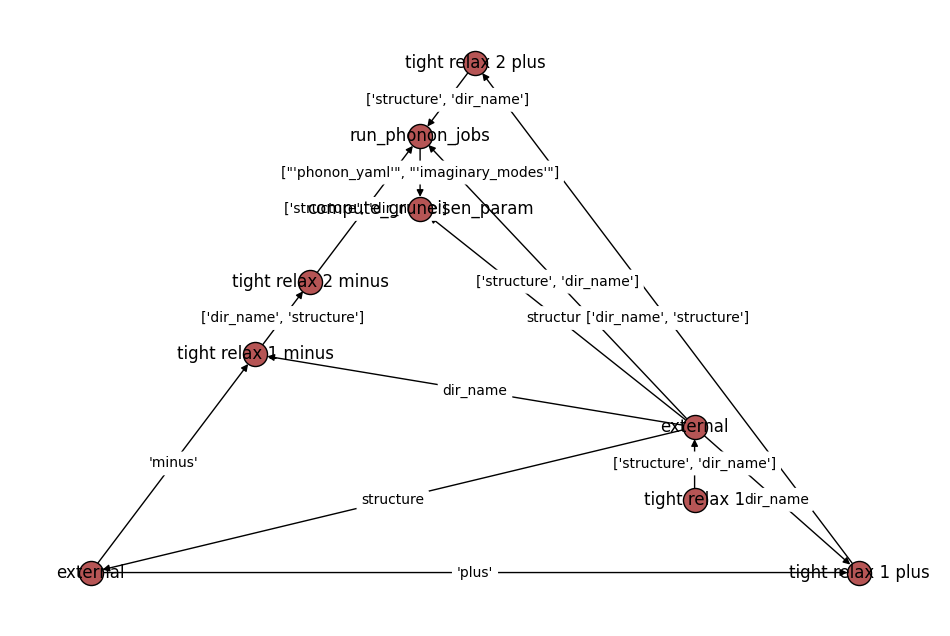

In [7]:
flow.draw_graph().show()

We now run the flow with  `run_locally`. We mock the run here. Normally, you would simply use `run_locally` without the `with mock_vasp`

In [ ]:
with mock_vasp(ref_paths=ref_paths) as mf:
    run_locally(
        flow,
        create_folders=True,
        ensure_success=True,
        raise_immediately=True,
        store=job_store,
    )

2025-02-18 12:38:35,160 INFO Started executing jobs locally
2025-02-18 12:38:35,166 INFO Starting job - tight relax 1 (6b623f99-071d-480c-8ac8-479d972be30f)


/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/pymatgen/io/vasp/outputs.py:1219: UserWarning: No POTCAR file with matching TITEL fields was found in

  warnings.warn("No POTCAR file with matching TITEL fields was found in\n" + "\n  ".join(potcar_paths))
Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-02-18 12:38:36,412 INFO Finished job - tight relax 1 (6b623f99-071d-480c-8ac8-479d972be30f)
2025-02-18 12:38:36,413 WARNING Response.stored_data is not supported with local manager.
2025-02-18 12:38:36,413 INFO Starting job - tight relax 2 (b42afe33-ab28-4e42-a369-2e177704454f)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp_8tauc6o/job_2025-02-18-11-38-36-413654-76125/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)
Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-02-18 12:38:37,846 INFO Finished job - tight relax 2 (b42afe33-ab28-4e42-a369-2e177704454f)
2025-02-18 12:38:37,849 WARNING Response.stored_data is not supported with local manager.
2025-02-18 12:38:37,850 INFO Starting job - shrink_expand_structure (08261a16-ff4a-419a-a89c-999ee27e4ade)
2025-02-18 12:38:37,874 INFO Finished job - shrink_expand_structure (08261a16-ff4a-419a-a89c-999ee27e4ade)
2025-02-18 12:38:37,875 INFO Starting job - tight relax 1 plus (e7b72351-99d3-424e-a873-84b76e626cd0)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp_8tauc6o/job_2025-02-18-11-38-37-875373-50276/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-18 12:38:38,444 INFO Finished job - tight relax 1 plus (e7b72351-99d3-424e-a873-84b76e626cd0)
2025-02-18 12:38:38,445 WARNING Response.stored_data is not supported with local manager.
2025-02-18 12:38:38,446 INFO Starting job - tight relax 1 minus (15c0576d-040c-48d4-8ae6-ceb6a878caf3)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp_8tauc6o/job_2025-02-18-11-38-38-445658-85717/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-18 12:38:39,168 INFO Finished job - tight relax 1 minus (15c0576d-040c-48d4-8ae6-ceb6a878caf3)
2025-02-18 12:38:39,172 WARNING Response.stored_data is not supported with local manager.
2025-02-18 12:38:39,174 INFO Starting job - tight relax 2 plus (f91a9d2a-9c62-4795-88bd-23724a9c6e33)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp_8tauc6o/job_2025-02-18-11-38-39-174044-74138/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-18 12:38:39,488 INFO Finished job - tight relax 2 plus (f91a9d2a-9c62-4795-88bd-23724a9c6e33)
2025-02-18 12:38:39,489 WARNING Response.stored_data is not supported with local manager.
2025-02-18 12:38:39,489 INFO Starting job - tight relax 2 minus (d8e82fd9-801b-439f-ab8b-db730e93fd75)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp_8tauc6o/job_2025-02-18-11-38-39-489438-74230/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-18 12:38:39,785 INFO Finished job - tight relax 2 minus (d8e82fd9-801b-439f-ab8b-db730e93fd75)
2025-02-18 12:38:39,785 WARNING Response.stored_data is not supported with local manager.
2025-02-18 12:38:39,787 INFO Starting job - run_phonon_jobs (4fb5b978-bf18-46fa-896e-cab68ef21071)
2025-02-18 12:38:39,937 INFO Finished job - run_phonon_jobs (4fb5b978-bf18-46fa-896e-cab68ef21071)
2025-02-18 12:38:39,954 INFO Starting job - get_supercell_size ground (17efbf7e-bb9d-4b25-8045-de7104f755ee)
2025-02-18 12:38:39,957 INFO Finished job - get_supercell_size ground (17efbf7e-bb9d-4b25-8045-de7104f755ee)
2025-02-18 12:38:39,958 INFO Starting job - generate_phonon_displacements ground (f352e600-73d3-4999-b5b2-ea81aa07bd7f)
2025-02-18 12:38:40,140 INFO Finished job - generate_phonon_displacements ground (f352e600-73d3-4999-b5b2-ea81aa07bd7f)
2025-02-18 12:38:40,141 INFO Starting job - run_phonon_displacements ground (6bc48ddc-b14d-4db5-8569-ff06cb4abc33)


/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/jobflow/core/flow.py:431: UserWarning: Some jobs are not connected, their ordering may be random
  for node in itergraph(graph):
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/jobflow/core/job.py:604: UserWarning: Initial magnetic moments will not be considered for the determination of the symmetry of the structure and thus will be removed now.
  response = function(*self.function_args, **self.function_kwargs)


2025-02-18 12:38:40,255 INFO Finished job - run_phonon_displacements ground (6bc48ddc-b14d-4db5-8569-ff06cb4abc33)
2025-02-18 12:38:40,263 INFO Starting job - dft phonon static 1/1 ground (6930d636-a9ef-437e-bc69-1c8c6a17ca58)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp_8tauc6o/job_2025-02-18-11-38-40-263414-56639/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-18 12:38:41,383 INFO Finished job - dft phonon static 1/1 ground (6930d636-a9ef-437e-bc69-1c8c6a17ca58)
2025-02-18 12:38:41,384 WARNING Response.stored_data is not supported with local manager.
2025-02-18 12:38:41,386 INFO Starting job - store_inputs ground (6bc48ddc-b14d-4db5-8569-ff06cb4abc33, 2)
2025-02-18 12:38:41,387 INFO Finished job - store_inputs ground (6bc48ddc-b14d-4db5-8569-ff06cb4abc33, 2)
2025-02-18 12:38:41,388 INFO Starting job - generate_frequencies_eigenvectors ground (b6906711-2019-482c-9593-9e070ac6a7b1)


/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_lattice']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_positions']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_types']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribut

In [9]:
job_store.connect()

result = job_store.query_one(
    {"name": "compute_gruneisen_param"},
    properties=[
        "output.gruneisen_band_structure",
        "output.gruneisen_parameter",
    ],
    load=True,
    sort={"completed_at": -1},  # to get the latest computation
)

<Axes: xlabel='$\\mathrm{Wave\\ Vector}$', ylabel='Frequencies (THz)'>

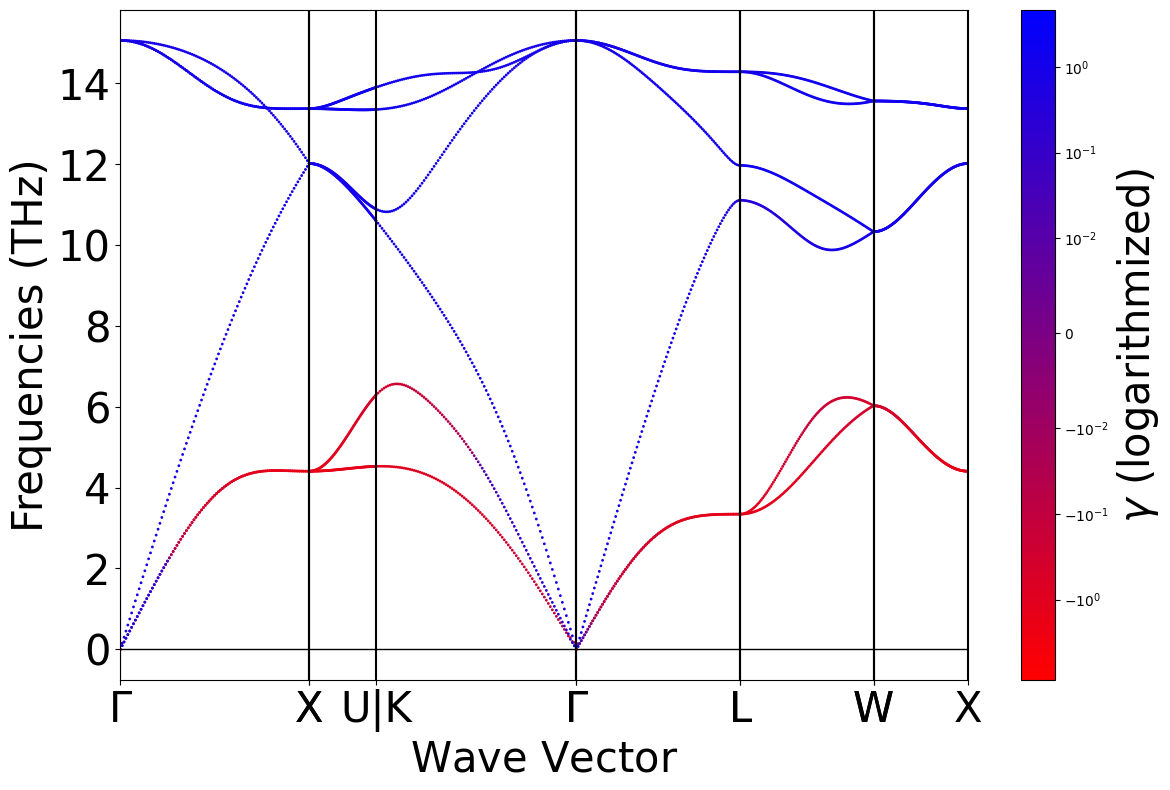

In [14]:
from pymatgen.phonon.gruneisen import GruneisenPhononBandStructureSymmLine
from pymatgen.phonon.plotter import GruneisenPhononBSPlotter

bs = GruneisenPhononBandStructureSymmLine.from_dict(
    result["output"]["gruneisen_band_structure"]
)
plt = GruneisenPhononBSPlotter(bs=bs)
plt.get_plot_gs(plot_ph_bs_with_gruneisen=True)